# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import progressbar

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 400)
pd.set_option('display.max_rows', 500)

import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.cluster import KMeans, MiniBatchKMeans

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV




# magic word for producing visualizations in notebook
%matplotlib inline


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
azdias_temp = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers_temp = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [4]:
int_cols = azdias_temp.select_dtypes('int64').columns.tolist()
float_cols = azdias_temp.select_dtypes('float64').columns.tolist()

azdias_temp[int_cols] = azdias_temp[int_cols].astype('float32')
azdias_temp[float_cols] = azdias_temp[float_cols].astype('float32')

int_cols = customers_temp.select_dtypes('int64').columns.tolist()
float_cols = customers_temp.select_dtypes('float64').columns.tolist()

customers_temp[int_cols] = customers_temp[int_cols].astype('float32')
customers_temp[float_cols] = customers_temp[float_cols].astype('float32')

## Part 0.1 Data Exploration

In [5]:
print("\t Azdias")
print("Shape:", azdias_temp.shape)
print('Total NaN values:', azdias_temp.isnull().sum().sum())
print("\t Customers")
print("Shape:", customers_temp.shape)
print("Total NaN values:", customers_temp.isnull().sum().sum())

	 Azdias
Shape: (891221, 366)
Total NaN values: 33492923
	 Customers
Shape: (191652, 369)
Total NaN values: 13864522


In [6]:
# Load the feature information and view the first 15 lines
feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header = 0)
del feat_info['Unnamed: 0']

new_header = feat_info.iloc[0]
feat_info = feat_info[1:]
feat_info.columns = new_header

In [7]:
feat_info.head(15)

,Attribute,Description,Value,Meaning
1,AGER_TYP,best-ager typology,-1,unknown
2,NaN,NaN,0,no classification possible
3,NaN,NaN,1,passive elderly
4,NaN,NaN,2,cultural elderly
5,NaN,NaN,3,experience-driven elderly
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
7,NaN,NaN,1,< 30 years
8,NaN,NaN,2,30 - 45 years
9,NaN,NaN,3,46 - 60 years
10,NaN,NaN,4,> 60 years


In [8]:
# Nan values from index 1-4 belongs to the same attribute as seen in the xlsx file, 
# so replacing NaN with the attribute name

feat_info['Attribute'] = feat_info['Attribute'].fillna(method = 'ffill')
feat_info['Description'] = feat_info['Description'].fillna(method = 'ffill')

In [9]:
# Some values in the dataset are missing but are not encoded as Nans
# We will find all such values and replace them with NaN

feat_info = feat_info[ (feat_info['Meaning'].str.contains('no ') | (feat_info['Meaning'].str.contains('unknown')))]
feat_info

,Attribute,Description,Value,Meaning
1,AGER_TYP,best-ager typology,-1,unknown
2,AGER_TYP,best-ager typology,0,no classification possible
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
12,ALTER_HH,main age within the household,0,unknown / no main age detectable
34,ANREDE_KZ,gender,"-1, 0",unknown
41,BALLRAUM,distance to next urban centre,-1,unknown
49,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
50,BIP_FLAG,business-flag indicating companies in the buil...,0,no company in the building
52,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
106,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown


In [10]:
feat_info.Meaning.value_counts()

unknown                                             232
no transaction known                                 34
no transactions known                                22
no Online-transactions within the last 12 months      3
no classification possible                            1
unknown / no main age detectable                      1
no company in the building                            1
no 1-2 family homes                                   1
almost no risk                                        1
no >10 family homes                                   1
no 3-5 family homes                                   1
no score calculated                                   1
no small office/home office                           1
no preowner                                           1
no 6-10 family homes                                  1
Name: Meaning, dtype: int64

In [11]:
filter = ['unknown','unknown / no main age detectable', 'no classification possible', 'no score calculated']
feat_info = feat_info[feat_info['Meaning'].isin(filter)]

In [12]:
# We now know all the missing values for a particular Attribute
# There are 292 attributes which contains Missing Values not
# encoded as NaNs.

missing_values = []

for attribute in feat_info['Attribute'].unique():
    vals = feat_info[feat_info['Attribute'] == attribute]['Value'].astype('str').str.cat(sep = ',')
    missing_val = vals.split(',')
    missing_val = list(map(np.float32, missing_val))
    missing_values.append(missing_val)
    
feat_missing_val = pd.DataFrame({'Attribute': feat_info['Attribute'].unique(), 'Missing_values': missing_values})
feat_missing_val

,Attribute,Missing_values
0,AGER_TYP,"[-1.0, 0.0]"
1,ALTERSKATEGORIE_GROB,"[-1.0, 0.0]"
2,ALTER_HH,[0.0]
3,ANREDE_KZ,"[-1.0, 0.0]"
4,BALLRAUM,[-1.0]
5,BIP_FLAG,[-1.0]
6,CAMEO_DEUG_2015,[-1.0]
7,CAMEO_DEUINTL_2015,[-1.0]
8,CJT_GESAMTTYP,[0.0]
9,D19_KK_KUNDENTYP,[-1.0]


In [13]:
# On manual inspection of the unique values of every columns, we found out that
# these three columns contains other missing values whose information is not
# provided in the DIAS attribute file.

# CAMEO_DEUINTL_2015 - -1, XX (missing value)
# CAMEO_DEU_2015 -  XX (missing value)
# CAMEO_DEUG_2015 - -1, X (missing value)

feat_missing_val.loc[6, 'Missing_values'] = [-1.0, 'XX'] #CAMEO_DEUG_2015
feat_missing_val.loc[7, 'Missing_values'] = ['XX']      #CAMEO_DEUINTL_2015

feat_missing_val = pd.concat([feat_missing_val, pd.DataFrame(
    {'Attribute':'CAMEO_DEU_2015', 'Missing_values': [[-1.0, 'X']]})], axis = 0)

# Changing Attribute name as it named differently in DIAS 
feat_missing_val.loc[7, 'Attribute'] = 'CAMEO_INTL_2015'

In [14]:
feat_missing_val

,Attribute,Missing_values
0,AGER_TYP,"[-1.0, 0.0]"
1,ALTERSKATEGORIE_GROB,"[-1.0, 0.0]"
2,ALTER_HH,[0.0]
3,ANREDE_KZ,"[-1.0, 0.0]"
4,BALLRAUM,[-1.0]
5,BIP_FLAG,[-1.0]
6,CAMEO_DEUG_2015,"[-1.0, XX]"
7,CAMEO_INTL_2015,[XX]
8,CJT_GESAMTTYP,[0.0]
9,D19_KK_KUNDENTYP,[-1.0]


In [15]:
feat_missing_val.Missing_values.value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[-1.0]         135
[-1.0, 9.0]     75
[-1.0, 0.0]     18
[0.0]            3
[XX]             1
[-1.0, XX]       1
[-1.0, X]        1
Name: Missing_values, dtype: int64

In [16]:

# D19_LETZTER_KAUF_BRANCHE - drop
# DSL_FLAG - datetime
# GEBAEUDETYP_RASTER, MIN_GEBAEUDEJAHR - year

### Part 0.2 Dealing with Missing Values

In [17]:
# Replacing missing values with NaN

count = 0
bar = progressbar.ProgressBar(maxval=azdias_temp.shape[1]+1, 
                              widgets=[progressbar.Bar('=', '[', ']'), ' ', 
                              progressbar.Percentage()])
bar.start()

for att in feat_missing_val['Attribute']:
    count+=1 
    bar.update(count)

    if att in azdias_temp.columns:
        na_map = feat_missing_val.loc[feat_missing_val['Attribute'] == att, 'Missing_values'].iloc[0]
        na_idx = azdias_temp.loc[:, att].isin(list(na_map))
        azdias_temp.loc[na_idx, att] = np.NaN
        
bar.finish()

# Some values are still not replaced with NaN, so replacing them manually
azdias_temp['CAMEO_DEU_2015'] = azdias_temp['CAMEO_DEU_2015'].replace('XX', np.NaN)
azdias_temp['CAMEO_DEUG_2015'] = azdias_temp['CAMEO_DEU_2015'].replace('XX', np.NaN)
azdias_temp['CAMEO_INTL_2015'] = azdias_temp['CAMEO_DEU_2015'].replace('XX', np.NaN)


[========================================================================] 100%


##### Looking distribution of Missing Values per column

Text(0.5, 1.0, 'Proportion of missing values in columns of Azdias Dataframe')

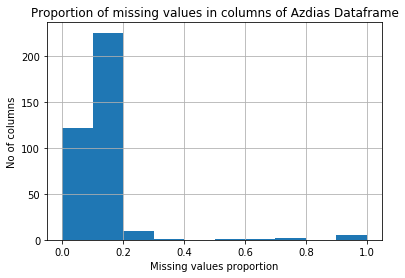

In [18]:
#Proportion of values missing in each column

proportion_col = azdias_temp.isnull().sum()/azdias_temp.shape[0]

proportion_col.hist()
plt.xlabel("Missing values proportion")
plt.ylabel("No of columns")
plt.title("Proportion of missing values in columns of Azdias Dataframe")

###### Dropping Columns with more than 30% values Missing

In [19]:
# From the above visualization we can see that most of the columns
# have less than 30% missing values. We will keep these columns and
# drop the rest.

cols_to_drop = proportion_col[proportion_col > 0.3].index.tolist()
azdias_temp = azdias_temp.drop(cols_to_drop, axis = 1)

In [20]:
print("{} columns dropped".format(len(cols_to_drop)))
print("Name of Columns dropped:", cols_to_drop)

10 columns dropped
Name of Columns dropped: ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']


count    356.000000
mean       0.094733
std        0.069889
min        0.000000
25%        0.005446
50%        0.118714
75%        0.121408
max        0.295041
dtype: float64


Text(0.5, 1.0, 'Distribution of Missing Values after Dropping Columns')

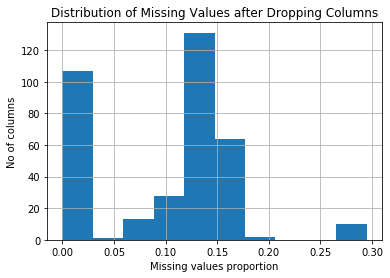

In [21]:
#Proportion of values missing in each column

proportion_col = azdias_temp.isnull().sum()/azdias_temp.shape[0]
print(proportion_col.describe())

proportion_col.hist()
plt.xlabel("Missing values proportion")
plt.ylabel("No of columns")
plt.title("Distribution of Missing Values after Dropping Columns")

##### Looking distribution of Missing Values per Row

count    891221.000000
mean         33.725096
std          75.555984
min           0.000000
25%           0.000000
50%           1.000000
75%          10.000000
max         254.000000
dtype: float64


Text(0.5, 1.0, 'Row-wise missing values')

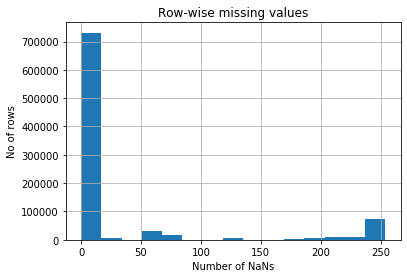

In [22]:
#Number of Missing Values per Row

proportion_row = azdias_temp.isnull().sum(axis = 1)
print(proportion_row.describe())


plt.figure()
proportion_row.hist(bins = 15)
plt.xlabel("Number of NaNs")
plt.ylabel("No of rows")
plt.title("Row-wise missing values")

##### Dropping rows with more than 25 NaN values

In [23]:
print("Number of rows dropped:", azdias_temp[azdias_temp.isnull().sum(axis =1) > 25].shape[0])

# Dropping Rows with more than 25 NaN values
# Total columns = 356
# Rows should not have more than 25 Nan values
# Therefore thresh = 306

azdias_temp.dropna(thresh = 331, axis = 0, inplace = True)
print("Shape:", azdias_temp.shape)

Number of rows dropped: 156810
Shape: (736411, 356)


## Part 0.3 Re-encoding Features

The Dataset contains Ordinal, Categorical and Mixed columns. We will have a look at these
columns and re-encode them if needed.

In [24]:
azdias_temp.dtypes

LNR                            float32
AKT_DAT_KL                     float32
ALTERSKATEGORIE_FEIN           float32
ANZ_HAUSHALTE_AKTIV            float32
ANZ_HH_TITEL                   float32
ANZ_KINDER                     float32
ANZ_PERSONEN                   float32
ANZ_STATISTISCHE_HAUSHALTE     float32
ANZ_TITEL                      float32
ARBEIT                         float32
BALLRAUM                       float32
CAMEO_DEU_2015                  object
CAMEO_DEUG_2015                 object
CAMEO_INTL_2015                 object
CJT_GESAMTTYP                  float32
CJT_KATALOGNUTZER              float32
CJT_TYP_1                      float32
CJT_TYP_2                      float32
CJT_TYP_3                      float32
CJT_TYP_4                      float32
CJT_TYP_5                      float32
CJT_TYP_6                      float32
D19_BANKEN_ANZ_12              float32
D19_BANKEN_ANZ_24              float32
D19_BANKEN_DATUM               float32
D19_BANKEN_DIREKT        

In [25]:
# We will need to re-encode these features
azdias_temp.select_dtypes(include = 'object')

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
1,8A,8A,8A,NaN,1992-02-10 00:00:00,W
2,4C,4C,4C,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2A,2A,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6B,6B,D19_SCHUHE,1992-02-12 00:00:00,W
5,8C,8C,8C,D19_ENERGIE,1992-02-12 00:00:00,W
...,...,...,...,...,...,...
891216,7A,7A,7A,D19_HAUS_DEKO,1992-02-10 00:00:00,W
891217,9D,9D,9D,D19_UNBEKANNT,1992-02-10 00:00:00,W
891218,4C,4C,4C,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
891219,9D,9D,9D,D19_UNBEKANNT,1992-02-12 00:00:00,W


###### Description of above Coluns

- CAMEO_DEU_2015 : CAMEO classification 2015 - Uppergroup
- CAMEO_DEUG_2015 : CAMEO classification 2015 - detailed classification
- CAMEO_INTL_2015 : CAMEO classification 2015 - international typology
- D19_LETZTER_KAUF_BRANCHE : No information provided
- EINGEFUEGT_AM : No information Provided
- OST_WEST_KZ : flag indicating the former GDR/FRG

We only keep OST_WEST_KZ columns, rest all are dropped

In [26]:
# it contains two values 'W' and 'O', coverting them to 1s and 0s
azdias_temp['OST_WEST_KZ'] = azdias_temp['OST_WEST_KZ'].astype('category').cat.codes

- **CAMEO_INTL_2015** codes can be decoded into two types, the firt digit of the code is related to the wealth and second digit is the type of family. So we will create two separate columns and then drop this one.

- **CAMEO_DEU_2015** is also encoded in the same way, where first and second digit have their own meaning but it's hard to infer from the values.  so we will just drop this column

In [27]:
azdias_temp['Wealth'] = azdias_temp['CAMEO_INTL_2015'].astype('str').str[1]  # to get the first digit
azdias_temp['Family_typ'] = azdias_temp['CAMEO_INTL_2015'].astype('str').str[0]  # to get the second digit

cols_to_drop.append('CAMEO_INTL_2015')
cols_to_drop.append('CAMEO_DEU_2015')

azdias_temp.drop(['CAMEO_INTL_2015', 'CAMEO_DEU_2015'], axis =1 , inplace = True)

In [28]:
# These columns contains too many levels and no description is provided for them.
# Dropping them for simplicity

cols_to_drop.append('D19_LETZTER_KAUF_BRANCHE')
cols_to_drop.append('EINGEFUEGT_AM')
cols_to_drop.append('VERDICHTUNGSRAUM')
cols_to_drop.append('ALTERSKATEGORIE_FEIN')

#dropping LNR column as it seems like a index
cols_to_drop.append('LNR') 


azdias_temp.drop(['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'LNR', 'VERDICHTUNGSRAUM',  'ALTERSKATEGORIE_FEIN' ], 
                 axis = 1, inplace = True)

print("Shape:", azdias_temp.shape)

Shape: (736411, 351)


In [29]:
# I looked through the DIAS file provided and found 20 variables of categorical 
# type (there were others too, but these looked more promising in terms of information they contain.)

cat_cols = [
     'CJT_GESAMTTYP',
     'D19_KONSUMTYP',
     'FINANZTYP',
     'FINANZ_ANLEGER',
     'FINANZ_SPARER',
     'GEBAEUDETYP',
     'GEMEINDETYP',
     'GFK_URLAUBERTYP',
     'HEALTH_TYP',
     'KBA05_HERSTTEMP',
     'KBA05_MAXHERST',
     'KBA05_MODTEMP',
     'LP_FAMILIE_FEIN',
     'LP_FAMILIE_GROB',
     'LP_LEBENSPHASE_GROB',
     'LP_STATUS_FEIN',
     'LP_STATUS_GROB',
     'MOBI_REGIO',
     'NATIONALITAET_KZ',
     'SHOPPER_TYP',
     'STRUKTURTYP',
     'WOHNLAGE',
     'ZABEOTYP', 
     'Wealth',
     'Family_typ']


#categorical but only contains 2 values, so no need to create dummy for these
#  'ANREDE_KZ',
#   VERS_TYP
#   OST_WEST_KZ

In [30]:
# Number of Unique values for above columns
count = 0
for col in cat_cols:
    val = azdias_temp[col].value_counts().nunique()
    print(col, ":",val)
    count+=val

print("Number of dummy variables:", count)

CJT_GESAMTTYP : 6
D19_KONSUMTYP : 7
FINANZTYP : 6
FINANZ_ANLEGER : 5
FINANZ_SPARER : 5
GEBAEUDETYP : 7
GEMEINDETYP : 7
GFK_URLAUBERTYP : 12
HEALTH_TYP : 3
KBA05_HERSTTEMP : 5
KBA05_MAXHERST : 5
KBA05_MODTEMP : 6
LP_FAMILIE_FEIN : 12
LP_FAMILIE_GROB : 6
LP_LEBENSPHASE_GROB : 13
LP_STATUS_FEIN : 10
LP_STATUS_GROB : 5
MOBI_REGIO : 6
NATIONALITAET_KZ : 3
SHOPPER_TYP : 4
STRUKTURTYP : 3
WOHNLAGE : 7
ZABEOTYP : 6
Wealth : 7
Family_typ : 10
Number of dummy variables: 166


##### Making Dummy Variables

In [31]:
for col in cat_cols:
    dummy_var = pd.get_dummies(azdias_temp[col], prefix = col)
    azdias_temp = pd.concat([azdias_temp, dummy_var], axis = 1)
        

# Dropping original cols which are dummified
azdias_temp.drop(cat_cols, axis = 1, inplace = True)
print("Shape:", azdias_temp.shape)

Shape: (736411, 492)


##### Preprocessing Method

In [32]:
def preprocessing(df, feat_missing_val, thres = None):
    '''
    Performs data cleaning steps on the dataframe
    
    args:
        df : dataframe to be cleaned
        feat_missing_val: dataframe containg missing values corresponding to an attribute
        columns_of_azdias : list of columns of azdias
        thres : threshold to keep number of NaNs in a row
    return:
        df : preprocessed dataframe
    '''
    
    
    # Replacig missing values with Nans
    for att in feat_missing_val['Attribute']:
        if att in azdias_temp.columns:
            na_map = feat_missing_val.loc[feat_missing_val['Attribute'] == att, 'Missing_values'].iloc[0]
            na_idx = df.loc[:, att].isin(na_map)
            df.loc[na_idx, att] = np.NaN
    
    # Some values are still not replaced with NaN, so replacing them manually
    df['KBA05_MAXHERST'] = df['KBA05_MAXHERST'].replace(9,np.NaN)
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace('XX', np.NaN)
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEU_2015'].replace('XX', np.NaN)
    df['CAMEO_INTL_2015'] = df['CAMEO_DEU_2015'].replace('XX', np.NaN)
    
    # COL OST_WEST_KZ  contains two values 'W' and 'O', coverting them to 1s and 0s
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].astype('category').cat.codes
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('category').cat.codes
    
    df['Wealth'] = df['CAMEO_INTL_2015'].astype('str').str[0]    # to get the first digit
    df['Family_typ'] = df['CAMEO_INTL_2015'].astype('str').str[1] #o get the last digit
    
    # For NaN values Wealth and Family_typ column would contain 'n' as we were
    # just fetching the first and the last digit. Replacing 'n' with NaN
    df['Wealth'] = df['Wealth'].replace('n', np.NaN)
    df['Family_typ'] = df['Family_typ'].replace('n', np.NaN)

    #dropping cols that are not in azdias 
    df = df.drop(list(set(cols_to_drop)), axis = 1)
    
    if thres!=None:
        #removing rows containing atleast 'thres' non-NaN values
        df.dropna(thresh = thres, axis = 0, inplace = True)
    
    
    cat_cols = [
     'CJT_GESAMTTYP',
     'D19_KONSUMTYP',
     'FINANZTYP',
     'FINANZ_ANLEGER',
     'FINANZ_SPARER',
     'GEBAEUDETYP',
     'GEMEINDETYP',
     'GFK_URLAUBERTYP',
     'HEALTH_TYP',
     'KBA05_HERSTTEMP',
     'KBA05_MAXHERST',
     'KBA05_MODTEMP',
     'LP_FAMILIE_FEIN',
     'LP_FAMILIE_GROB',
     'LP_LEBENSPHASE_GROB',
     'LP_STATUS_FEIN',
     'LP_STATUS_GROB',
     'MOBI_REGIO',
     'NATIONALITAET_KZ',
     'SHOPPER_TYP',
     'STRUKTURTYP',
     'WOHNLAGE',
     'ZABEOTYP',
     'Wealth',
     'Family_typ']


    
    #Creating Dummies
    for col in cat_cols:
        dummy_var = pd.get_dummies(df[col], prefix = col)
        df = pd.concat([df, dummy_var], axis = 1)
        

    # Dropping original cols which are dummified
    df.drop(cat_cols, axis = 1, inplace = True)
    
    return df

##### Loading and Cleaning Customers & Demographic Data

In [33]:
# load in the data
azdias = pd.read_csv('data\\azdias.csv', index_col = 0)
customers = pd.read_csv('data\\customers.csv',index_col = 0)


#Customer dataframe have 3 Extra Columns so we will drop those columns
customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis =1 , inplace = True)


#Changing dataype of Numeric columns to float32
int_cols = azdias.select_dtypes('int64').columns.tolist()
float_cols = azdias.select_dtypes('float64').columns.tolist()

azdias[int_cols] = azdias[int_cols].astype('float32')
azdias[float_cols] = azdias[float_cols].astype('float32')

int_cols = customers.select_dtypes('int64').columns.tolist()
float_cols = customers.select_dtypes('float64').columns.tolist()

customers[int_cols] = customers[int_cols].astype('float32')
customers[float_cols] = customers[float_cols].astype('float32')

In [34]:
# There's a column 'GEBAEUDETYP' which creates a problem while making
# dummy variables.  On close inspection we found out that it's due the 
# value it takes in azdias and customers dataframe. Lets have a look 
# at the value_count() of this column

# Let's have a close look at the values that this extra column takes
print(azdias['GEBAEUDETYP'].value_counts())
print(customers['GEBAEUDETYP'].value_counts())

1.0    460465
3.0    178668
8.0    152476
2.0      4935
4.0       900
6.0       628
5.0         1
Name: GEBAEUDETYP, dtype: int64
1.0    95145
3.0    23655
8.0    20475
2.0     2057
4.0      251
6.0      142
Name: GEBAEUDETYP, dtype: int64


In [35]:
# We can see that 'GEBAEUDETYP' does not take value '5.0' in the customers
# dataframe, while it is present in azdias dataframe with value_count of 1.
# To fix this problem, we remove the rows( only 1 row) containing value 5 from azdias 

azdias = azdias[(azdias['GEBAEUDETYP'] == 5) == False]

print(azdias['GEBAEUDETYP'].value_counts())

1.0    460465
3.0    178668
8.0    152476
2.0      4935
4.0       900
6.0       628
Name: GEBAEUDETYP, dtype: int64


In [36]:
print('**** Before Cleaning **** \n')
print('Azdias:', azdias.shape)
print('Customers:', customers.shape)

#Preprocessing
azdias = preprocessing(azdias, feat_missing_val, thres = 306)
customers = preprocessing(customers, feat_missing_val, thres = 240)

print('\n\n**** After Cleaning **** \n')
print('Azdias:', azdias.shape)
print('Customers:', customers.shape)

**** Before Cleaning **** 

Azdias: (891220, 366)
Customers: (191652, 366)


**** After Cleaning **** 

Azdias: (737287, 495)
Customers: (140371, 495)


## Part 0.4 Imputing and Scaling

In [37]:
np.setdiff1d( customers.columns,azdias.columns)

array([], dtype=object)

In [38]:
# Imputing Missing values with Mean
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
azdias_imputed = imputer.fit_transform(azdias.values.astype('float32'))


# Scaling the Data
scaler_orig = StandardScaler()
azdias_scaled = scaler_orig.fit_transform(azdias_imputed)

In [39]:
azdias_scaled_df = pd.DataFrame(data=azdias_scaled, index= azdias.index, columns=azdias.columns)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Principal Component Analysis (PCA)

In this section we will perform PCA on the dataset to find the prinicipal components which explains the most variability in the dataset and wil also reduce the number of dimensions

In [40]:
#Performing PCA
pca_temp = PCA()
azdias_pca_temp = pca_temp.fit_transform(azdias_scaled_df)

variance = pca_temp.explained_variance_ratio_
variance_cumsum = np.cumsum(np.round(variance, 3)*100)
#total components
tot_components = len(variance)

In [41]:
variance_cumsum[250]

90.19999999999996

In [42]:
def plot(variance_cumsum,tot_components, n_components = None):
    # Frist Plot
    plt.figure(figsize=(13,15))
    plt.subplot(2, 1, 1)
    plt.bar(np.arange(tot_components), variance_cumsum,color = 'lightsteelblue')
    plt.ylabel('Cumulative Variance (%)')
    plt.xlabel('Number of Principal Components')
    plt.xticks(np.linspace(0,600, 10, endpoint=False))
    #plt.yticks(np.linspace(0,100, 5, endpoint= True))
    plt.title('Variance Vs no. of Principal Components')

    if n_components!=None:
        
        plt.hlines(y=variance_cumsum[n_components], xmin=0, xmax=n_components, color='black', linestyles='-',zorder=5)
        plt.vlines(x=n_components, ymin=0, ymax=variance_cumsum[n_components], color='black', linestyles='-',zorder=6)
    else:

        #Second Plot
        plt.subplot(2, 1, 2)
        plt.bar(np.arange(tot_components), variance,color = 'lightsteelblue')
        plt.xticks(np.linspace(0,600, 10, endpoint=False))
        plt.xlabel('Number of Principal Components')
        plt.ylabel('Variance Explained (%)')
        plt.title('Variance Explained per Principal Component');

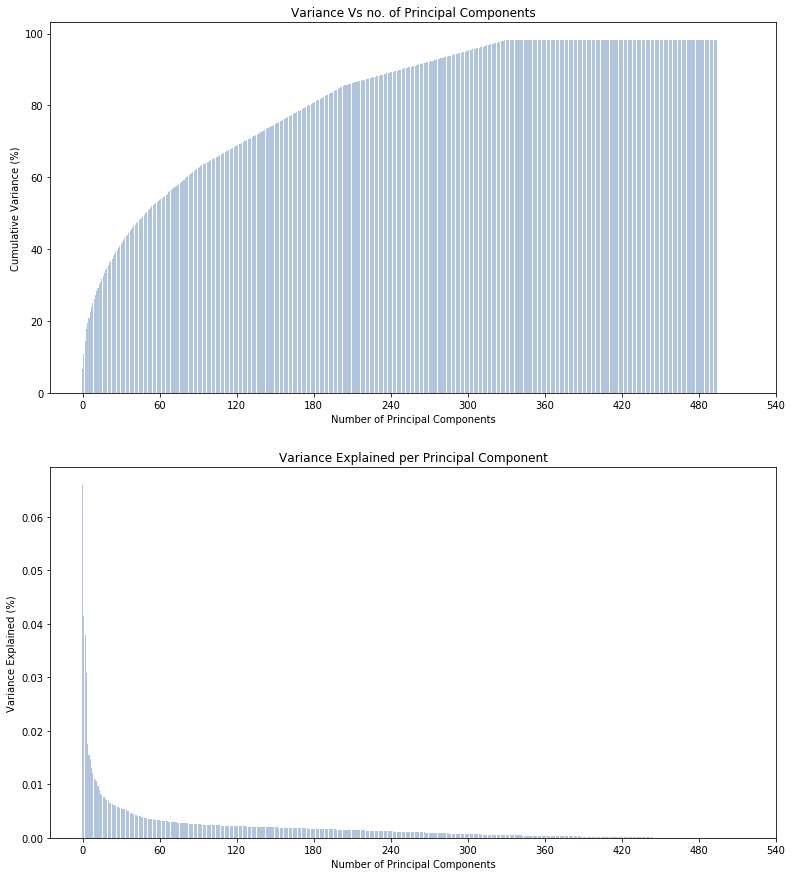

In [43]:
plot(variance_cumsum, tot_components)

In [44]:
variance_cumsum[250]

90.19999999999996

Based on above plots,we select 250 principal components which explains 90% of variance in the data

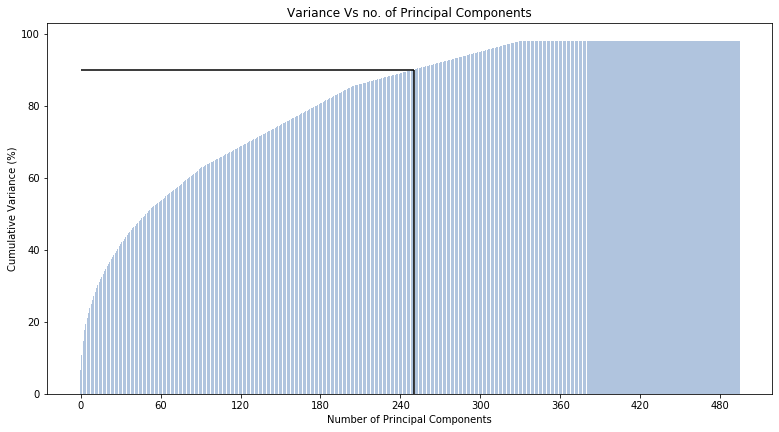

In [45]:
plot(variance_cumsum, tot_components, n_components = 250)

##### Refiting PCA with 270 Components

In [46]:
azdias_scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737287 entries, 1 to 891220
Columns: 495 entries, AKT_DAT_KL to Family_typ_a
dtypes: float32(495)
memory usage: 1.4 GB


In [47]:
#Performing PCA
pca = PCA(n_components = 250 )
azdias_pca = pca.fit_transform(azdias_scaled_df)

variance = pca.explained_variance_ratio_
variance_cumsum = np.cumsum(np.round(variance, 3)*100)
#total components
tot_components = len(variance)

In [48]:
# code taken from stack-overflow
# https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis

# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE``
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = azdias.columns.tolist()
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items(), columns = ['Prinicipal Component', 'Feature Name'])
pca_270_feature_names = df['Feature Name'].values.tolist()
df

,Prinicipal Component,Feature Name
0,PC1,PLZ8_ANTG1
1,PC2,PRAEGENDE_JUGENDJAHRE
2,PC3,KBA13_HERST_BMW_BENZ
3,PC4,VK_ZG11
4,PC5,KBA13_BJ_2000
5,PC6,ANREDE_KZ
6,PC7,KBA05_SEG2
7,PC8,KBA05_KW1
8,PC9,KBA05_HERST3
9,PC10,LP_FAMILIE_GROB_5.0


##### Interpreting First 3 Principal Componets

In [49]:
def pca_results(full_dataset, pca, component_number):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results where figure 1 shows all features sorted
    and figure 2 shows the top 3 negative and positive features.
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    # Create a bar plot visualization for 1st figure (all columns sorted)
    fig1, ax1 = plt.subplots(figsize = (15,8))

    # Plot the feature weights as a function of the components
    components.iloc[component_number-1, :].sort_values().plot(ax = ax1, kind = 'bar');
    ax1.set_ylabel("Feature Weights")
    ax1.set_xticklabels(components.iloc[component_number-1, :].sort_values().index, rotation=90)
   
    # Create a bar plot visualization for 2nd figure (top and bottom 3 columns)
    fig2, ax2 = plt.subplots(figsize = (6,3))
    
    # Plot the feature weights as a function of the components
    components.iloc[component_number-1, :].sort_values().iloc[[0, 1, 2, -3, -2, -1]].plot(ax = ax2, kind = 'bar');
    ax2.set_ylabel("Feature Weights")
    ax2.set_xticklabels(components.iloc[component_number-1, :].sort_values().index, rotation=90)

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

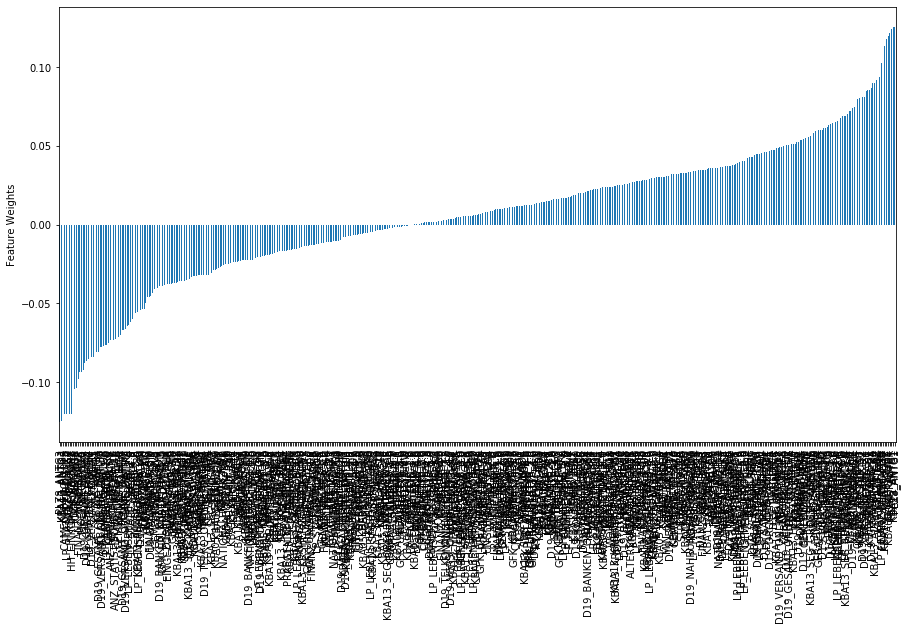

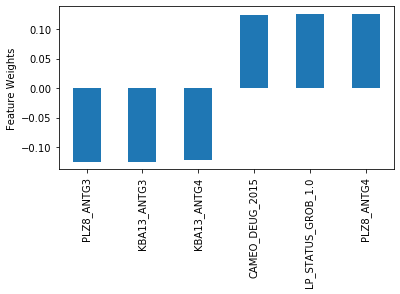

In [50]:
# Analyzing 1st Principal Component
pc1_df = pca_results(azdias_scaled_df, pca, component_number = 1)

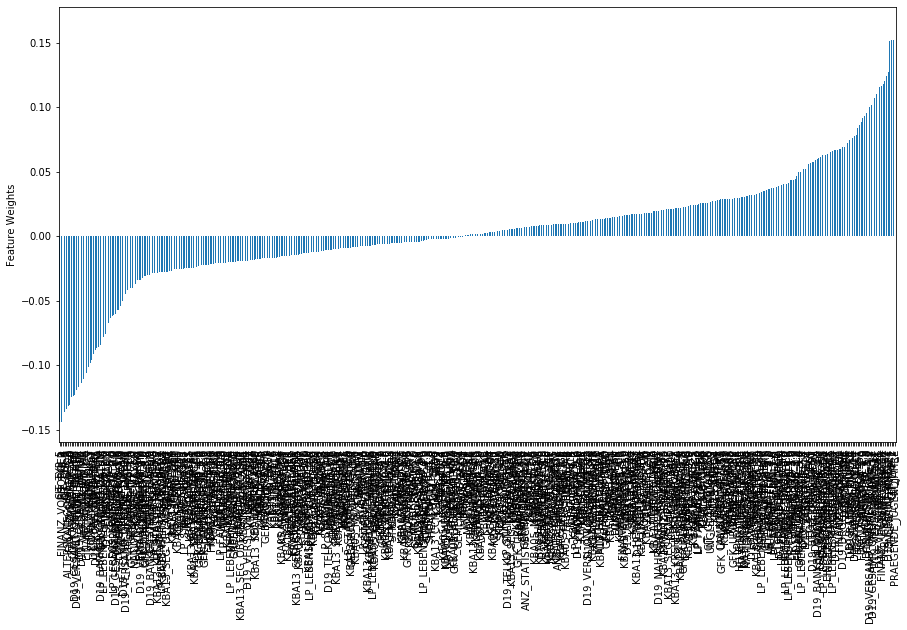

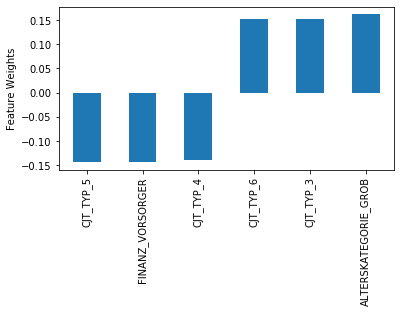

In [51]:
# Analyzing 2nd Principal Component
pc2_df = pca_results(azdias_scaled_df, pca, component_number = 2)

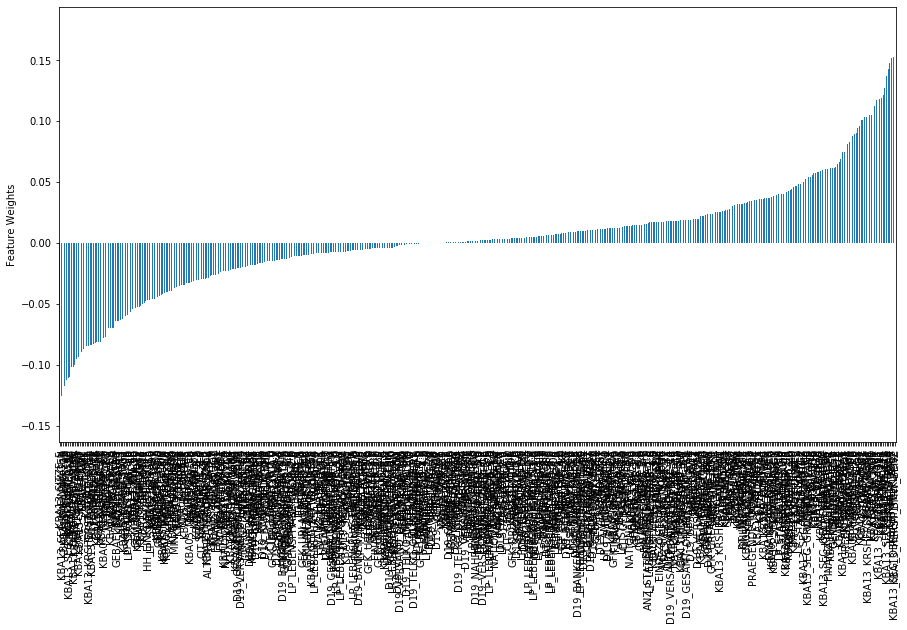

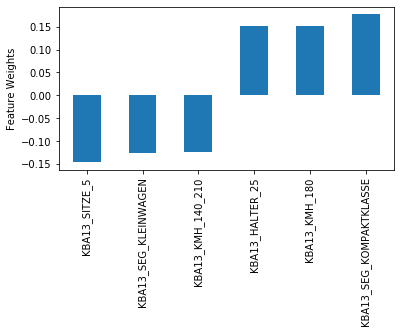

In [52]:
# Analyzing 3rd Principal Component
pc3_df = pca_results(azdias_scaled_df, pca, component_number = 3)

## Intrepeting Prinicpal Components

**Here we list the top 3 (postive and negative) correlated weights for first 3 principal components**

The intrepretation isn't very clear about the principal components as many of the features associated with principal components do not have description. So it's hard to interpret.

----------------------------------------------------------------------------------------------------------
#### Prinipal Component-1
Principal Component-1 is related to household with Less-Income earners.

*Positive*
* **PLZ8_ANTG4** : number of >10 family houses in the PLZ8
* **LP_STATUS_GROB_1.0** : social status rough (LOW-INCOME EARNERS)
* **CAMEO_DEUG_2015** : CAMEO classification 2015 - Uppergroup


*Negative*
* **KBA13_ANTG4** : No description given
* **KBA13_ANTG3** : No description given
* **PLZ8_ANTG3**: number of 6-10 family houses in the PLZ8

----------------------------------------------------------------------------------------------------------
#### Prinipal Component-2
Principal Component is related to the financial typology typically extreme money savers.

*Positive*
* **ALTERSKATEGORIE_GROB** : age classification through prename analysis
* **CJT_TYP_3** : No description given
* **CJT_TYP_6** : No description given


*Negative*
* **CJT_TYP_4** : No description given
* **CJT_TYP_5** : No description given
* **FINANZ_VORSORGER** : financial typology: be prepared

----------------------------------------------------------------------------------------------------------
#### Prinipal Component-3 
Principal Component-3 is related to the young owners who have cars belonging to the category of lower middle class. 

*Positive*
* **KBA13_SEG_KOMPAKTKLASSE** : share of lower midclass cars (Ford Focus etc.) in the PLZ8
* **KBA13_KMH_180** : share of cars with max speed between 110 km/h and 180km/h within the PLZ8
* **KBA13_HALTER_25** : share of car owners between 21 and 25 within the PLZ8

*Negative*
* **KBA13_KMH_140_210** : share of cars with max speed between 140 and 210 km/h within the PLZ8
* **KBA13_SEG_KLEINWAGEN** : share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8
* **KBA13_SITZE_5** : number of cars with 5 seats in the PLZ8
----------------------------------------------------------------------------------------------------------

### K-Means Clustering 
#### Using Elbow method to determine the optimal number of clusters

In [54]:
import time


scores = []
clusters = list(range(2,31))
for cluster in clusters:
    
    # run k-means clustering on the data and...
    kmeans_minibatch= MiniBatchKMeans(n_clusters = cluster, random_state = 42)
    kmeans_fit_obj = kmeans_minibatch.fit(azdias_pca)
    
    # compute the average within-cluster distances.
    score = np.abs(kmeans_fit_obj.score(azdias_pca))
    scores.append(score)

In [55]:
scores

[314086050.0,
 308160600.0,
 304766270.0,
 301766270.0,
 295392160.0,
 294172260.0,
 287553380.0,
 287468580.0,
 284318940.0,
 282522050.0,
 283710530.0,
 280560300.0,
 280612160.0,
 278106780.0,
 276617600.0,
 277495230.0,
 275475400.0,
 276916030.0,
 273965570.0,
 274797600.0,
 284384260.0,
 285297250.0,
 273793020.0,
 274015300.0,
 271467420.0,
 272009820.0,
 270016260.0,
 269304160.0,
 270008800.0]

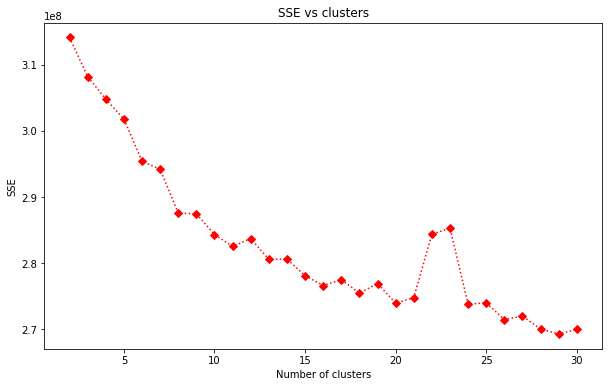

In [56]:
fig = plt.figure(figsize = (10, 6))
plt.ylabel("SSE")
plt.xlabel("Number of clusters")
plt.title("SSE vs clusters")
plt.plot(clusters, np.abs(scores), linestyle = ':', marker = 'D', color = 'r')

In [57]:
# We select 10 clusters and refit data to kmeans

start = time.time()

kmeans = KMeans(n_clusters = 10, random_state = 42)
azdias_cluster_labels = kmeans.fit_predict(azdias_pca)

end = time.time()

print("Total time elpased", (end-start)/60)

Total time elpased 17.597117344538372


#### Imputing, Scaling and Performing PCA on Customers dataset

In [58]:
customers = pd.read_csv('data\\customers.csv',index_col = 0)

int_cols = customers.select_dtypes('int64').columns.tolist()
float_cols = customers.select_dtypes('float64').columns.tolist()

customers[int_cols] = customers[int_cols].astype('float32')
customers[float_cols] = customers[float_cols].astype('float32')



#Customer dataframe have 3 Extra Columns so we will drop those columns
customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis =1 , inplace = True)
customers = preprocessing(customers, feat_missing_val, thres = 240)
print('Customers:', customers.shape)

Customers: (140371, 495)


In [59]:
np.setdiff1d(azdias.columns, customers.columns)

array([], dtype=object)

In [60]:
customers.head()

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP_RASTER,GEBURTSJAHR,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,...,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SOHO_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,ANREDE_KZ,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,D19_KONSUMTYP_1.0,D19_KONSUMTYP_2.0,D19_KONSUMTYP_3.0,D19_KONSUMTYP_4.0,D19_KONSUMTYP_5.0,D19_KONSUMTYP_6.0,D19_KONSUMTYP_9.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,FINANZ_ANLEGER_1.0,FINANZ_ANLEGER_2.0,FINANZ_ANLEGER_3.0,FINANZ_ANLEGER_4.0,FINANZ_ANLEGER_5.0,FINANZ_SPARER_1.0,FINANZ_SPARER_2.0,FINANZ_SPARER_3.0,FINANZ_SPARER_4.0,FINANZ_SPARER_5.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,GEMEINDETYP_11.0,GEMEINDETYP_12.0,GEMEINDETYP_2

In [61]:
azdias.head()

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP_RASTER,GEBURTSJAHR,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,...,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SOHO_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,ANREDE_KZ,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,D19_KONSUMTYP_1.0,D19_KONSUMTYP_2.0,D19_KONSUMTYP_3.0,D19_KONSUMTYP_4.0,D19_KONSUMTYP_5.0,D19_KONSUMTYP_6.0,D19_KONSUMTYP_9.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,FINANZ_ANLEGER_1.0,FINANZ_ANLEGER_2.0,FINANZ_ANLEGER_3.0,FINANZ_ANLEGER_4.0,FINANZ_ANLEGER_5.0,FINANZ_SPARER_1.0,FINANZ_SPARER_2.0,FINANZ_SPARER_3.0,FINANZ_SPARER_4.0,FINANZ_SPARER_5.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,GEMEINDETYP_11.0,GEMEINDETYP_12.0,GEMEINDETYP_2

In [62]:
# Imputing and Scaling
customers_imputed = imputer.transform(customers.values.astype('float32'))
customers_scaled = scaler_orig.transform(customers_imputed)

#PCA
customers_pca = pca.transform(customers_scaled)

#Predicting Clusters
customers_cluster_labels = kmeans.predict(customers_pca)

In [63]:
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = azdias.columns.tolist()
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items(), columns = ['Principal Components', 'Feature'])

In [64]:
most_important_names[:5]

['PLZ8_ANTG1',
 'PRAEGENDE_JUGENDJAHRE',
 'KBA13_HERST_BMW_BENZ',
 'VK_ZG11',
 'KBA13_BJ_2000']

In [65]:
df

,Principal Components,Feature
0,PC1,PLZ8_ANTG1
1,PC2,PRAEGENDE_JUGENDJAHRE
2,PC3,KBA13_HERST_BMW_BENZ
3,PC4,VK_ZG11
4,PC5,KBA13_BJ_2000
5,PC6,ANREDE_KZ
6,PC7,KBA05_SEG2
7,PC8,KBA05_KW1
8,PC9,KBA05_HERST3
9,PC10,LP_FAMILIE_GROB_5.0


In [66]:
general_pop = []
customers_pop = []

for i  in range(10):
    general_pop.append((azdias_cluster_labels == i).sum() / len(azdias_cluster_labels))
    customers_pop.append((customers_cluster_labels == i).sum() /len(customers_cluster_labels))

  
    
# Dataframe with clusters
compare_dict = {'Cluster': range(10),
               'Population': general_pop,
               'Customers': customers_pop}


df_compare = pd.DataFrame(compare_dict)
melt_df = pd.melt(df_compare, id_vars = 'Cluster', var_name = 'Dataset', value_name = 'Proportion')
melt_df.head()

,Cluster,Dataset,Proportion
0,0,Population,0.036606
1,1,Population,0.115349
2,2,Population,0.146311
3,3,Population,0.104849
4,4,Population,0.080335


In [68]:
np.setdiff1d(azdias.columns, customers.columns)

array([], dtype=object)

In [69]:
azdias_pca_df = azdias[most_important_names]
customers_pca_df = customers[most_important_names]

azdias_pca_df['Cluster'] = azdias_cluster_labels
customers_pca_df['Cluster'] = customers_cluster_labels

In [70]:
# Checking for over and under representations of the clusters of Customers and Demographic Data

azdias_prop = azdias_pca_df['Cluster'].value_counts()/azdias_pca_df.shape[0]
customers_prop = customers_pca_df['Cluster'].value_counts()/customers_pca_df.shape[0]

diff = azdias_prop - customers_prop

max_index = diff.sort_values(ascending=False).index[0]
max_diff = diff.sort_values(ascending=False).iloc[0]
min_index = diff.sort_values(ascending=False).index[-1]
min_diff = diff.sort_values(ascending=False).iloc[-1]

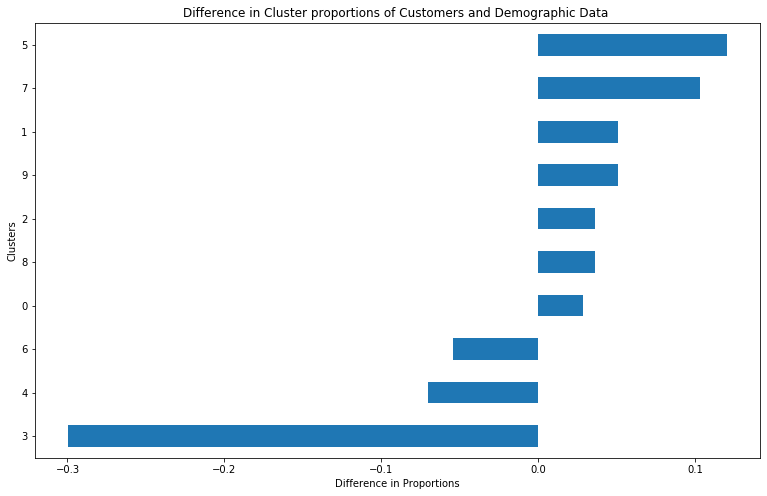

In [71]:
fig, ax = plt.subplots(figsize = (13, 8))

diff.sort_values().plot(kind = 'barh')
ax.set_xlabel('Difference in Proportions')
ax.set_ylabel('Clusters')
ax.set_title('Difference in Cluster proportions of Customers and Demographic Data ')

plt.show()

In [72]:
cols_to_infer = ['PLZ8_ANTG4',
                 'LP_STATUS_GROB_1.0',
                 'PLZ8_ANTG3',
                 'ALTERSKATEGORIE_GROB',
                 'FINANZ_VORSORGER',
                 'KBA13_SEG_KOMPAKTKLASSE',
                 'KBA13_HALTER_25',
                 'KBA13_SEG_KLEINWAGEN',
                'FINANZ_SPARER_5.0',
                'PRAEGENDE_JUGENDJAHRE' ]

In [73]:
print("Overrepresented Cluster:", max_index)
print("Underrepresented Cluster:", min_index)

Overrepresented Cluster: 5
Underrepresented Cluster: 3


In [74]:
# Function to transform centroids back to the original data space based on cluster number
def infer_cluster(index, cols):
    
    # Subset the customers_cluster dataframe by the selected index
    cluster = customers_pca_df[customers_pca_df['Cluster'] == index]
    cluster_drop = cluster.drop('Cluster', axis=1)
    
    # Perform inverse PCA and inverse scaling to return to the original values
    cluster_pca = pca.inverse_transform(cluster_drop)
    cluster_scaler = scaler_orig.inverse_transform(cluster_pca)
    
    # Create a new dataframe of the cluster and reuse the feature columns
    cluster_final = pd.DataFrame(cluster_pca, columns=cols)
    return cluster_final

In [75]:
cols = customers_pca_df.columns.tolist()[:-1]
print(len(cols))
over_cluster = infer_cluster(max_index, customers.columns.tolist())
under_cluster = infer_cluster(min_index, customers.columns.tolist())

250


In [76]:
# Compare the differences between the target and non-target groups
over_mean = over_cluster[cols_to_infer].describe().loc['mean']
under_mean = under_cluster[cols_to_infer].describe().loc['mean']
mean_df = pd.concat([over_mean, under_mean], axis=1)
mean_df.columns = ['Target', 'Non-Target']

In [77]:
mean_df

,Target,Non-Target
PLZ8_ANTG4,0.949950,0.241045
LP_STATUS_GROB_1.0,-0.764288,-0.557663
PLZ8_ANTG3,0.698459,0.088030
ALTERSKATEGORIE_GROB,-2.305699,-1.798144
FINANZ_VORSORGER,-0.209282,0.344754
KBA13_SEG_KOMPAKTKLASSE,1.386661,0.754826
KBA13_HALTER_25,-0.681783,-0.831212
KBA13_SEG_KLEINWAGEN,2.052118,1.088043
FINANZ_SPARER_5.0,0.454595,0.004565
PRAEGENDE_JUGENDJAHRE,1.335271,0.696433


In [78]:
temp = mean_df['Target'] - mean_df['Non-Target']
temp.sort_values(ascending = False)

KBA13_SEG_KLEINWAGEN       0.964075
PLZ8_ANTG4                 0.708904
PRAEGENDE_JUGENDJAHRE      0.638838
KBA13_SEG_KOMPAKTKLASSE    0.631836
PLZ8_ANTG3                 0.610429
FINANZ_SPARER_5.0          0.450029
KBA13_HALTER_25            0.149429
LP_STATUS_GROB_1.0        -0.206625
ALTERSKATEGORIE_GROB      -0.507555
FINANZ_VORSORGER          -0.554036
dtype: float64

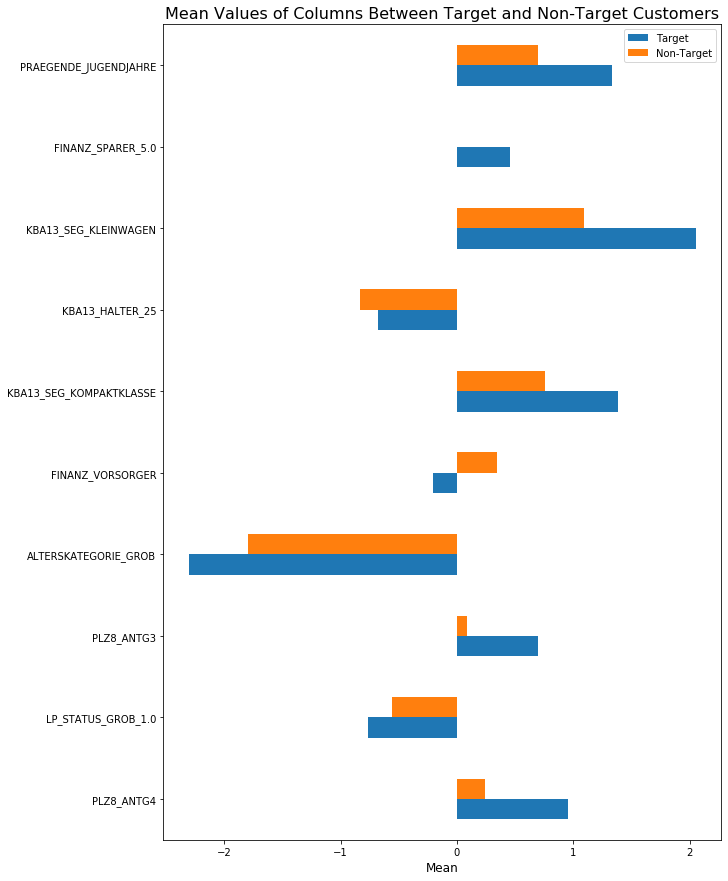

In [79]:
# Plot the means of the columns of interests for the target and non-target groups
fig, ax = plt.subplots(figsize=(10,15))
plt.title("Mean Values of Columns Between Target and Non-Target Customers", fontsize=16)
plt.xlabel("Mean", fontsize=12)
mean_df.plot.barh(ax=ax);

### Conclusion

Looking at the above visualization, all features except <font color='red'>KBA13_AUTOQUOTE</font> shows a clear distinction 

* **PRAEGENDE_JUGENDJAHRE** : dominating movement in the person's youth (avantgarde or mainstream)
* **FINANZ_SPARER_5.0** : financial typology: money saver (VERY LOW)
* **KBA13_SEG_KLEINWAGEN**: share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8
* **KBA13_HALTER_25** : share of car owners between 21 and 25 within the PLZ8
* **KBA13_SEG_KOMPAKTKLASSE** : share of lower midclass cars (Ford Focus etc.) in the PLZ8
* **FINANZ_VORSORGER** : financial typology: be prepared
* **LP_STATUS_GROB_1.0** : social status (ROUGH)
* **ALTERSKATEGORIE_GROB** : age classification through prename analysis 
* **PLZ8_ANTG3** : number of 6-10 family houses in the PLZ8
* **LP_STATUS_GROB_1.0**: social status rough
* **PLZ8_ANTG4** : number of >10 family houses in the PLZ8






The target audience is <font color='blue'>*between 21 and 25 years of age*</font>, <font color='blue'>*saves less money*</font>, <font color ='blue'>*not financially prepared*</font>, <font color='blue'>*dominating movement in the youth*</font> and lives in a locality where <font color='blue'>*number of family houses is greater than 10 in the PLZ8*</font>

## Part 3: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [115]:
mailout_train = pd.read_csv('data\\Udacity_MAILOUT_052018_TRAIN.csv', index_col = 0)

In [116]:
response = mailout_train['RESPONSE']
mailout_train.drop('RESPONSE', axis =1 , inplace = True)
mailout_train = preprocessing(mailout_train, feat_missing_val)

In [117]:
mailout_train.shape

(42962, 495)

In [118]:
# Checking for columns that are not in mailout_train
missing = list(np.setdiff1d(customers.columns, mailout_train.columns))
missing

['FINANZTYP_1.0',
 'FINANZTYP_2.0',
 'FINANZTYP_3.0',
 'FINANZTYP_4.0',
 'FINANZTYP_5.0',
 'FINANZTYP_6.0',
 'FINANZ_ANLEGER_1.0',
 'FINANZ_ANLEGER_2.0',
 'FINANZ_ANLEGER_3.0',
 'FINANZ_ANLEGER_4.0',
 'FINANZ_ANLEGER_5.0',
 'FINANZ_SPARER_1.0',
 'FINANZ_SPARER_2.0',
 'FINANZ_SPARER_3.0',
 'FINANZ_SPARER_4.0',
 'FINANZ_SPARER_5.0',
 'HEALTH_TYP_-1.0',
 'HEALTH_TYP_1.0',
 'HEALTH_TYP_2.0',
 'HEALTH_TYP_3.0',
 'NATIONALITAET_KZ_0.0',
 'NATIONALITAET_KZ_1.0',
 'NATIONALITAET_KZ_2.0',
 'NATIONALITAET_KZ_3.0',
 'SHOPPER_TYP_-1.0',
 'SHOPPER_TYP_0.0',
 'SHOPPER_TYP_1.0',
 'SHOPPER_TYP_2.0',
 'SHOPPER_TYP_3.0',
 'ZABEOTYP_1.0',
 'ZABEOTYP_2.0',
 'ZABEOTYP_3.0',
 'ZABEOTYP_4.0',
 'ZABEOTYP_5.0',
 'ZABEOTYP_6.0']

In [119]:
# Add the missing column with default value of 0
for m in missing:
    mailout_train[m] = 0
    mailout_train[m] = mailout_train[m].astype('uint8')
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42962 entries, 0 to 42961
Columns: 530 entries, AKT_DAT_KL to ZABEOTYP_6.0
dtypes: float64(262), int64(62), int8(2), uint8(204)
memory usage: 115.0 MB


In [120]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostRegressor 
from sklearn.ensemble import GradientBoostingRegressor 
from xgboost.sklearn import XGBRegressor 
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
#from sklearn.impute import KNNImputer


#Using 7 folds
skf = StratifiedKFold(n_splits=7, random_state=42)

In [93]:
clf_A = AdaBoostRegressor(random_state=42)
clf_B = XGBRegressor(random_state=42)
clf_C = GradientBoostingRegressor(random_state=42)


#knn_imputer = KNNImputer(n_neighbors=5)

In [94]:
clf_scores = {}

for i, clf in enumerate([clf_A, clf_B, clf_C]):
    #Pipeline creation
    pipeline = Pipeline([
        ('imputer', imputer),
        ('scaler', scaler_orig),
        ('clf', clf)
    ])

    k = 0
    fold_scores = []
    print('\t Classifer:', i+1)
    
    #7-fold validation
    for train_index, test_index in skf.split(mailout_train, response):
        k+=1
        print('Fold ',k),
        
        #Spliting data into Training and Test
        X_train, X_test = mailout_train.iloc[train_index], mailout_train.iloc[test_index]
        y_train, y_test = response.iloc[train_index], response.iloc[test_index]

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        auc_score = roc_auc_score(y_test, y_pred)
        fold_scores.append(auc_score)
        print(auc_score)

    clf_scores[clf] = fold_scores

	 Classifer: 1
Fold  1
0.7342786816926844
Fold  2
0.7918460990814218
Fold  3
0.718031004184827
Fold  4
0.7735804409555483
Fold  5
0.7662384181870284
Fold  6
0.7159633636971491
Fold  7
0.7681672730746185
	 Classifer: 2
Fold  1
0.5586092830227996
Fold  2
0.6243195315077532
Fold  3
0.5909375054263835
Fold  4
0.6255036514731805
Fold  5
0.6200427235387596
Fold  6
0.6206234423709828
Fold  7
0.6252648512057242
	 Classifer: 3
Fold  1
0.7244808036256924
Fold  2
0.7882516626439078
Fold  3
0.7446626091788363
Fold  4
0.7910204586701864
Fold  5
0.7717308243385234
Fold  6
0.7224652437065275
Fold  7
0.7582049600986461


In [95]:
results = pd.DataFrame(clf_scores)
results.columns = ['AdaBoost', 'Xgboost','GradientBoost' ]
results

,AdaBoost,Xgboost,GradientBoost
0,0.734279,0.558609,0.724481
1,0.791846,0.624320,0.788252
2,0.718031,0.590938,0.744663
3,0.773580,0.625504,0.791020
4,0.766238,0.620043,0.771731
5,0.715963,0.620623,0.722465
6,0.768167,0.625265,0.758205


In [96]:
results.describe()

,AdaBoost,Xgboost,GradientBoost
count,7.000000,7.000000,7.000000
mean,0.752586,0.609329,0.757260
std,0.029670,0.025473,0.028150
min,0.715963,0.558609,0.722465
25%,0.726155,0.605490,0.734572
50%,0.766238,0.620623,0.758205
75%,0.770874,0.624792,0.779991
max,0.791846,0.625504,0.791020


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('data\\Udacity_MAILOUT_052018_TEST.csv', index_col =0 )

In [ ]:
mailout_test.head()

In [ ]:
mailout_test_clean = preprocessing(mailout_test, feat_missing_val)

In [ ]:
# Check for missing columns in cleand Mail_out_test
missing = list(np.setdiff1d(customers.columns, mailout_test_clean.columns))
missing

In [ ]:
# Add the missing column with default value of 0
for m in missing:
    mailout_test_clean[m] = 0
    mailout_test_clean[m] = mailout_test_clean[m].astype('uint8')
mailout_test_clean.info()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor 


clf_grad = GradientBoostingRegressor(random_state=42)



#Pipeline creation
pipeline = Pipeline([
    ('imputer', imputer),
    ('scaler', scaler_orig),
    ('clf', clf_grad)
])
    

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

auc_score = roc_auc_score(y_test, y_pred)
auc_score

In [ ]:
predictions = pipeline.predict(mailout_test_clean)

In [ ]:
results = pd.DataFrame({'LNR': mailout_test['LNR'], 'RESPONSE': predictions})

In [ ]:
results.to_csv('submission.xlsx')